# Test Accuracy of Test Set

This notebook is used to test the combined accuracy of the Digit crop + CNN predictions on the given labels

### Mount to Collab Folder

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Load Dependencies

In [0]:
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, Dropout
from keras.models import Model, Sequential
from keras import layers
import numpy as np
import pandas as pd
import os
from random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow as tf
import cv2

### Set Input Location

In [0]:
analog_dir_ts = "/content/drive/My Drive/Team Bergere/Optimizer/Data/optimizer/HQ_analog_test_digits_Test/Test_set/"

### Define Function to Load Images and the process them, then return as a list


In [0]:
def image_resizer(input_file,c1,c2):
    """
    Inputs - 
    input_file - Image file to be processed
    c1 - Width of image shape
    c2 - Height dimension of image shape
    
    Process - 
    In case of digits where the image is very low width, a buffer is added on the left and right of the image
    
    This is done by repeating the leftmost column n times and the rightmost column m times so that the output dimension is 224 on width
    
    This is followed by a simple resize to make the height 224
    
    The padding on the left and right is done since in most cases of the digit '1', a simple resize would distort the image
    
    Output -
    Processed Image in the right dimensions
    
    """
    adj = input_file

    if adj.shape[1]<c1:
        addit_r  = int(np.floor((c1-adj.shape[1])/2))
        rightadd = np.repeat(adj[:,-1],addit_r).reshape(len(adj[:,-1]),addit_r)
        addit_l  = int(np.ceil((c1-adj.shape[1])/2))
        leftadd  = np.repeat(adj[:,0],addit_l).reshape(len(adj[:,0]),addit_l)
        
        adj = np.concatenate((leftadd,adj,rightadd),axis=1)

    
 
    adj = cv2.resize(adj,(c1,c2),interpolation=cv2.INTER_AREA)
  
    return adj
  
  


# Load images from a location
def load_image(loc):
    """
    Using the OpenCV package to load a set of images and return a list of their arrays
    
    Arguments - 
    loc - Location of a set of Processed Image Files
    
    Returns -
    templist - List of processed image arrays
    """
    templist = []
    origin = []
    position = []
    for file in os.listdir(loc):
        if "png" in file or 'jpg' in file:
            img_tc1 = cv2.imread(loc+file)
            img_tc1 = cv2.cvtColor(img_tc1, cv2.COLOR_BGR2GRAY)
            temp = image_resizer(img_tc1,target_size[0],target_size[1])
            templist.append(temp)
            origin.append(file[:-5])
            position.append(file[-5])
    return templist,origin,position






## Load Cropped Digit Images for Analog Readings into the notebook

In [0]:
"""
Folder structure includes one folder for each class, containing the images falling within that class. 

There are 11 folders ranging from 0 to 10, referring to each digit, with 10 referring to no digit or just noise.

"""


# Define a dictionary of classes (0 to 10)

classrange_a = dict()

for i in range(11):
    classrange_a[i] = str(i)+'/'

# Define Target Size of Input file

target_size = (224,224)

### Load Data from Test Folder

In [0]:
    
# Validation Set
analog_set_ts = list() # List to contain all validation image arrays
img_analog_class_t = dict() # Dictionary to contain all validation image arrays split by class
origins = list()
positions = list()

# Load Data into dictionary
for i in range(11):
    response = load_image(analog_dir_ts+classrange_a[i])
    img_analog_class_t[i] = response[0]
    [origins.append(x) for x in response[1]]
    [positions.append(x) for x in response[2]]
    
  

# Test for badly loaded files    
flag = 'Load Complete'
for i in img_analog_class_t.keys():
  if len(img_analog_class_t[i])!=len([x for x in img_analog_class_t[i] if x is not None]):
    flag = 'Loading Error'

print(flag)  
  
  
# Split Dictionary into List    
for k in img_analog_class_t.keys():
  for i in img_analog_class_t[k]:
    analog_set_ts.append(i)

Load Complete


### Generate Training and Validation labels based on loaded Data

In [0]:
"""
Training and validation labels contain the classes that the individual images fall into.

These will be arrays with values of 11 classes from 0 to 10

"""

# Generate array with labels

labels_analog_ts = np.concatenate(((np.repeat(0,len(img_analog_class_t[0]))),
                                 (np.repeat(1,len(img_analog_class_t[1]))),
                                 (np.repeat(2,len(img_analog_class_t[2]))),
                                 (np.repeat(3,len(img_analog_class_t[3]))),
                                 (np.repeat(4,len(img_analog_class_t[4]))),
                                 (np.repeat(5,len(img_analog_class_t[5]))),
                                 (np.repeat(6,len(img_analog_class_t[6]))),
                                 (np.repeat(7,len(img_analog_class_t[7]))),
                                 (np.repeat(8,len(img_analog_class_t[8]))),
                                 (np.repeat(9,len(img_analog_class_t[9]))),
                               (np.repeat(10,len(img_analog_class_t[10])))))


len(labels_analog_ts)

76

#### Example of the Testing Image

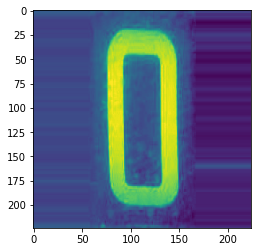

In [0]:
fig, ax = plt.subplots()
ax.imshow(analog_set_ts[0])

In [0]:
# Check if the Training set has correct number of labels

len(analog_set_ts),len(labels_analog_ts)

(76, 76)

## Generate CNN Model

### Convert the Training and Validation sets to 4 dimensional arrays

In [0]:
"""
Inputs to the model need to be 4 dimensional arrays instead of a list of arrays. 

This is rectified by conversion using np.stack

"""

x_test = np.stack(analog_set_ts)

if len(x_test.shape)==3:
  temp = x_test[:,:,:,np.newaxis]
  x_test = np.concatenate((temp,temp,temp),axis=3)
  
x_test.shape

(76, 224, 224, 3)

### Load Pre Trained Model


A CNN model was trained on augmented and training data and saved. This will be used to predict on the test set

In [0]:
taken_model = tf.keras.models.load_model('/content/drive/My Drive/Team Bergere/Optimizer/Notebooks/Models/model_analog_v1_.11.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Test Model Accuracy on the Validation Set

In [0]:
taken_model.evaluate(x_test,labels_analog_ts)

76/76 [==============================] - 3s 41ms/sample - loss: 1.2321 - acc: 0.6842


[1.2320901218213534, 0.68421054]

#### The CNN model for detecting the digit from the image has an accuracy of 0.68

### Class-wise Evaluation of accuracy

Check the performance of each individual class in the test set based on its labels.

In [0]:
res = dict()

for i in range(11):
  img_set = list()
  img_val = list()
  counter = 0
  for el in img_analog_class_t[i]:
    img_set.append(el)
    img_val.append(i)
  
  img_set = np.stack(img_set)
  if len(img_set.shape)==3:
    temp = img_set[:,:,:,np.newaxis]
    img_set = np.concatenate((temp,temp,temp),axis=3)
  img_val = np.asarray(img_val)
  
  res[i] = taken_model.evaluate(img_set,img_val)
  
res

9/9 [==============================] - 0s 5ms/sample - loss: 1.4733 - acc: 0.5556


{0: [0.4439612925052643, 0.8333333],
 1: [1.0474472045898438, 0.8],
 2: [2.9022319316864014, 0.6],
 3: [0.9892077445983887, 0.6],
 4: [0.16419315338134766, 1.0],
 5: [0.00015876170073170215, 1.0],
 6: [0.08993406593799591, 1.0],
 7: [4.0151543617248535, 0.0],
 8: [3.9614784717559814, 0.16666667],
 9: [2.291022777557373, 0.0],
 10: [1.4733420610427856, 0.5555556]}

The model performs poorly for 7, 8 and 9, but is good for all other classes

### Calculate Predictions based on Model on Test Set

In [0]:
preds = taken_model.predict_classes(x_test)
preds

array([ 0,  0,  0,  0,  0,  4,  3,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0, 10,  1,  1,  1,  1,
        1,  1,  1,  3,  1,  0,  2,  2,  0,  8,  2,  3,  3,  0,  0,  3,  4,
        4,  4,  4,  5,  5,  6,  1, 10,  0,  8,  0,  0,  0, 10,  0,  2, 10,
        7, 10, 10, 10,  4, 10,  1,  0])

### Compute Overall Accuracy of Entire Model

In [0]:
len(origins),len(positions),len(preds)

(76, 76, 76)

#### Generate a dataframe with the images and the corresponding digits in each position, to evaluate overall model performance

In [0]:
total_preds = pd.DataFrame()

total_preds['origin'] = origins
total_preds['position'] = positions
total_preds['predictions'] = preds

total_preds.head()

,origin,position,predictions
0,00d4904613d2aa43a2d911fa77a8ae00f8a64fac,0,0
1,00ec9bd05f6d3b9771526d4190ac99a0cd5cfddc,2,0
2,00ec9bd05f6d3b9771526d4190ac99a0cd5cfddc,0,0
3,0a03ff6ef4661817813387f347627373602efbea,0,0
4,00daab3e561e37286be49ed197bf5aaba589fafe,1,0


In [0]:
# Pivot the position to columns 
temp = total_preds.pivot(columns='position', index="origin", values="predictions").reset_index()


In [0]:
# Rename Columns
list_cols = ['origin']
for i in range(1,len(temp.columns)):
  list_cols.append('pos_'+str(i))
  
list_cols

['origin', 'pos_1', 'pos_2', 'pos_3', 'pos_4', 'pos_5', 'pos_6', 'pos_7']

In [0]:
temp.columns = list_cols


### Define function to combine the digits in each of the images into one string

In [0]:
def combine_columns(rowline):
  """
  Inputs -
  
  Each Row of the image level dataframe with digits in each position
  
  Task -
  
  The function combines the digits into one, ignoring 10s and NaNs
  
  Output -
  
  String of digits in the image based on position

  """
  list_cols = temp.columns
  response = ''
  for i in range(1,len(list_cols)):
    if not np.isnan(rowline[i]) and rowline[i]<10:
      response = response+str(int(rowline[i]))
  return response




def error_free_conv(numb):
  """
  Convert string to number without error
  """
  
  try:
    ret = int(numb)
  except:
    ret = 0
  return ret

In [0]:
tempo = temp
tempo['Combined'] = tempo.apply(lambda x: combine_columns(x), axis=1)
tempo['Numeric']  = tempo.apply(lambda x: error_free_conv(x['Combined']), axis=1)
tempo

,origin,pos_1,pos_2,pos_3,pos_4,pos_5,pos_6,pos_7,Combined,Numeric
0,00b4df21fc7774ebe26658797c5e78f1e57ac05c,0.0,0.0,3.0,0.0,NaN,NaN,NaN,0030,30
1,00d4904613d2aa43a2d911fa77a8ae00f8a64fac,0.0,0.0,3.0,1.0,1.0,NaN,NaN,00311,311
2,00daab3e561e37286be49ed197bf5aaba589fafe,3.0,0.0,6.0,1.0,10.0,NaN,NaN,3061,3061
3,00ec9bd05f6d3b9771526d4190ac99a0cd5cfddc,0.0,0.0,0.0,4.0,0.0,NaN,NaN,00040,40
4,0a03ff6ef4661817813387f347627373602efbea,0.0,0.0,1.0,3.0,0.0,NaN,NaN,00130,130
5,0a0893c514a32196aeb1dfd238f89f971fef0134,0.0,1.0,2.0,0.0,NaN,NaN,NaN,0120,120
6,0a0f34d1705019f3c46b7a2f480a7668ab785005,4.0,0.0,1.0,2.0,0.0,0.0,0.0,4012000,4012000
7,0a29d0d870ebb28ae0859435560796adda6b8b1c,0.0,0.0,0.0,4.0,6.0,NaN,NaN,00046,46
8,0a475ba0e54b7c6f618b0de7a1947070dd66103c,10.0,10.0,4.0,4.0,8.0,10.0,NaN,448,448
9,0a65fb248a82abb3a1dd0a57df927ce56b0cbe1b,10.0,0.0,2.0,2.0,3.0,1.0,NaN,02231,2231


### Load Test Labels

In [0]:
test_label_dir = 'drive/My Drive/Team Bergere/Optimizer/Data/optimizer/test_set/'
hq_analog_labels = pd.read_excel(test_label_dir + 'HQ_analog_test/hq_analog_test.xls')
hq_analog_labels['origin'] = hq_analog_labels.apply(lambda x: x['image'][:-4], axis=1)
hq_analog_labels = hq_analog_labels[['origin','label']]

# Input manually done labels
hq_analog_labels.label = ['0110','00311','00161','00048','00132','00193','01298','00040','00422','00223','01768','00518','00294','00583','00224','00417','00081']
hq_analog_labels.head()

,origin,label
0,00b4df21fc7774ebe26658797c5e78f1e57ac05c,0110
1,00d4904613d2aa43a2d911fa77a8ae00f8a64fac,00311
2,00daab3e561e37286be49ed197bf5aaba589fafe,00161
3,00ec9bd05f6d3b9771526d4190ac99a0cd5cfddc,00048
4,0a03ff6ef4661817813387f347627373602efbea,00132


### Merge the two to compare results

In [0]:
combined_results = pd.merge(tempo,hq_analog_labels)
combined_results

,origin,pos_1,pos_2,pos_3,pos_4,pos_5,pos_6,pos_7,Combined,Numeric,label
0,00b4df21fc7774ebe26658797c5e78f1e57ac05c,0.0,0.0,3.0,0.0,NaN,NaN,NaN,0030,30,0110
1,00d4904613d2aa43a2d911fa77a8ae00f8a64fac,0.0,0.0,3.0,1.0,1.0,NaN,NaN,00311,311,00311
2,00daab3e561e37286be49ed197bf5aaba589fafe,3.0,0.0,6.0,1.0,10.0,NaN,NaN,3061,3061,00161
3,00ec9bd05f6d3b9771526d4190ac99a0cd5cfddc,0.0,0.0,0.0,4.0,0.0,NaN,NaN,00040,40,00048
4,0a03ff6ef4661817813387f347627373602efbea,0.0,0.0,1.0,3.0,0.0,NaN,NaN,00130,130,00132
5,0a0893c514a32196aeb1dfd238f89f971fef0134,0.0,1.0,2.0,0.0,NaN,NaN,NaN,0120,120,00193
6,0a0f34d1705019f3c46b7a2f480a7668ab785005,4.0,0.0,1.0,2.0,0.0,0.0,0.0,4012000,4012000,01298
7,0a29d0d870ebb28ae0859435560796adda6b8b1c,0.0,0.0,0.0,4.0,6.0,NaN,NaN,00046,46,00040
8,0a475ba0e54b7c6f618b0de7a1947070dd66103c,10.0,10.0,4.0,4.0,8.0,10.0,NaN,448,448,00422
9,0a65fb248a82abb3a1dd0a57df927ce56b0cbe1b,10.0,0.0,2.0,2.0,3.0,1.0,NaN,02231,2231,00223


### Comparison of computed labels and test labels

The accuracy metric will look at the Combined column with the label column. This is basically comparing the combined predicted digits and the label generated by manually looking at the test data

The accuracy metric we are going to employ here is by comparing digit by digit matches between predicted and test labels. The denominator we have chosen is the total number of digits in the predicted column. 

In case of unmatched sizes, leading digits are either deleted or 0's are padded **on the Predicted label** to match the size of the Testing label

This is shown in the following example -

In [0]:
example_df = pd.DataFrame()
example_df['Predicted'] = ['00122','0532','6120','769','435','5275','05284']
example_df['Test Label'] = ['00122','00532','0612','69','5435','52751','274']
example_df['Predicted Processed'] = ['00122','00532','6120','69','0435','05275','284']
example_df['Accurate Digits'] = [5,5,0,2,3,0,2]
example_df['Total Test Digits'] = [5,5,4,2,4,5,3]
example_df

,Predicted,Test Label,Predicted Processed,Accurate Digits,Total Test Digits
0,00122,00122,00122,5,5
1,0532,00532,00532,5,5
2,6120,0612,6120,0,4
3,769,69,69,2,2
4,435,5435,0435,3,4
5,5275,52751,05275,0,5
6,05284,274,284,2,3


In the case of the previously shown examples, the accuracy will be computed as the sum of accurate digits divided by the sum of the total digits

= 17/28 = 60.71%



### Generate Function to calculate accuracy as described

In [0]:
def array_comparison(op,ip):
  
  """
  Inputs -
  op, ip = lists with the two inputs. First is the test label and second is the predictions
  
  Outputs -
  Computed accuracy as described above
  
  """
  num = 0
  den = 0
  for i in range(len(op)):
    diflen = len(str(ip[i]))-len(str(op[i]))
    if diflen>=0:
      ip_proc = str(ip[i])[diflen:]
    if diflen<0:
      ip_proc = ''
      for j in range(-diflen):
        ip_proc = ip_proc+'0'
      ip_proc = ip_proc+str(ip[i])
    for k in range(len(ip_proc)):
      den = den +1
      if ip_proc[k]==str(op[i])[k]:
        num = num+1
  return (num/den)
  
  
    

In [0]:
array_comparison(list(combined_results['label']),list(combined_results['Combined']))

0.5945945945945946

### Result - The model is trained on the Analog data + Augmented Data and evaluated at a 59.5% accuracy based on the test set